# Spotify K Means Algorithm

## Preface


Welcome, friendly reader! In this notebook is my exploratory process into attempting to cluster my own Spotify liked songs into useful recommendations (affectionately called blobs). Using my own data as an example case, I want to be able to provide crispy clustering visualizations for Spotify users as a new way to find recommended songs, as well as take a crack at designing what goes on when Spotify recommends songs to me and you on a daily basis. Below are my analytical first steps in achieving that lofty goal.

## Importing Packages

In [1]:
# data analysis
import pandas as pd
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# plots/visualization
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# to enable API get requests through python
import spotipy
from spotipy.oauth2 import SpotifyOAuth

Spotipy: https://spotipy.readthedocs.io/en/2.18.0/#authorization-code-flow

## Wrangling Spotify Data

In [2]:
# GET request for all track ids
scope = "user-library-read"

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope))
track_ids = []


SAVED_TRACKS_LIMIT = 20
i = 0

print("num ids:", end=" ")

# for each API request of 20 tracks
while True: 
    response = sp.current_user_saved_tracks(offset=SAVED_TRACKS_LIMIT*i)

    for idx, item in enumerate(response['items']):
        track = item['track']
        track_ids.extend([track['id']])
#         print(idx, track['artists'][0]['name'], " – ", track['name'])

    # progress bar
    if(len(track_ids) % 100 == 0):
        print(len(track_ids), end=" ")
    
    # either end loop once no more tracks to add or increment counter
    if not response['next']:
        break
    
    i += 1
    
print("success!")
    
# ensure that all track ids are unique (not duplicating weirdly)
assert len(track_ids) == len(np.unique(track_ids)), f'Tracks ids not read in properly, as only {len(np.unique(track_ids))}/{len(track_ids)} track IDs are unique'

num ids: 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 success!


In [3]:
# get audio features for each track using track_ids

AUDIO_FEATURES_LIMIT = 100
num_requests = int(len(track_ids)/AUDIO_FEATURES_LIMIT)
remainder = len(track_ids)%AUDIO_FEATURES_LIMIT

assert num_requests*AUDIO_FEATURES_LIMIT+remainder == len(track_ids), f'math is wrong: {num_requests*AUDIO_FEATURES_LIMIT+remainder}, {len(track_ids)}'

# initialize lists
audio_features = []

print(f'going to {num_requests}...')

# read in audio features by 100s for all of track_ids (limit is 100)
for i in range(num_requests):
    # create range of track ids to use
    lo = i*AUDIO_FEATURES_LIMIT
    hi = (i+1)*AUDIO_FEATURES_LIMIT
    response = sp.audio_features(tracks=track_ids[lo:hi])

    # add to relevant list
    for j in range(len(response)):
        audio_features.extend([[response[j]['acousticness'], response[j]['danceability'], 
                              response[j]['energy'], response[j]['instrumentalness'], 
                              response[j]['liveness'], response[j]['speechiness'], 
                              response[j]['valence']]])

    # progress bar
    print(i, end =" ")

# get remaining 
if(remainder > 0):
    for j in range(0,remainder):
        audio_features.extend([[response[j]['acousticness'], response[j]['danceability'], 
                              response[j]['energy'], response[j]['instrumentalness'], 
                              response[j]['liveness'], response[j]['speechiness'], 
                              response[j]['valence']]])
    
print("success!")

assert len(track_ids) == len(audio_features), f'length of feature list is {len(audio_features)} while track_ids is {len(track_ids)}'

going to 52...
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 success!


In [4]:
# load all audio features data into dataframe
data = pd.DataFrame(audio_features, columns=['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence'])
data.head(5)

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence
0,0.149,0.644,0.811,0.000473,0.1700,0.0517,0.817
1,0.605,0.621,0.713,0.000008,0.1030,0.1020,0.609
2,0.366,0.746,0.765,0.001560,0.0799,0.0540,0.972
3,0.499,0.839,0.475,0.011400,0.3190,0.1900,0.667
4,0.324,0.604,0.573,0.101000,0.1030,0.1890,0.759


My next job was to plot histograms and make sure that I had a decent distribution of values from 0 to 1.


Here, I made sure my process was working properly by validating my charts with https://www.klangspektrum.digital/home, which shows your spread of various traits. Below are my histograms, followed by some of these images for reference

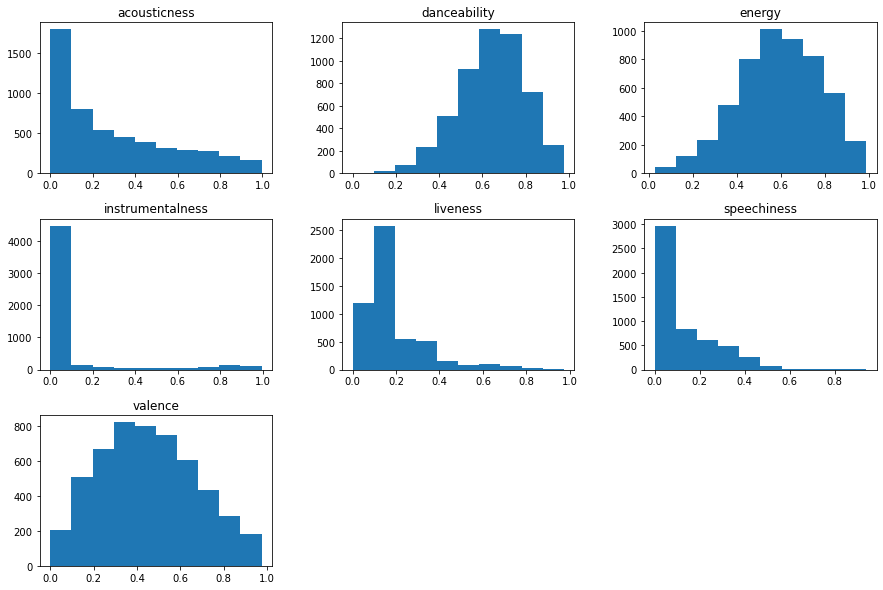

In [5]:
charts = data.hist(grid=False, bins=10, layout=(3,3), figsize=(15,10))

<img src="files/acousticness.png" width=400 height=130 style="float:left"/>
<img src="files/danceability.png" width=400 height=130/>
<img src="files/energy.png" width=400 height=130 style="float:left"/>
<img src="files/instrumentalness.png" width=400 height=130 />
<img src="files/liveness.png" width=400 height=130 style="float:left" />
<img src="files/speechiness.png" width=400 height=130 />
<img src="files/valence.png" width=400 height=130 style="float:left" />

## Determining the Optimal Number of Clusters 

To determine the optimal cluster of numbers, I chose to use the average silhouette method. The average silhouette method is a useful metric for my use case, as the optimal number of clusters has the highest average silhouette score. As a result, when I am trying to automate this entire process for users of my website, I can automate the entire algorithmic process by getting the cluster number associated with the maximum score.

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.29432425030102455
For n_clusters = 3 The average silhouette_score is : 0.2880305349046948
For n_clusters = 4 The average silhouette_score is : 0.21865675431457032
For n_clusters = 5 The average silhouette_score is : 0.19797333714542972
For n_clusters = 6 The average silhouette_score is : 0.2054117199401686
For n_clusters = 7 The average silhouette_score is : 0.18731053603112438
For n_clusters = 8 The average silhouette_score is : 0.19306534180843185
For n_clusters = 9 The average silhouette_score is : 0.18529423093305297
For n_clusters = 10 The average silhouette_score is : 0.18831021858318203
For n_clusters = 11 The average silhouette_score is : 0.1706049175938647
For n_clusters = 12 The average silhouette_score is : 0.16684226970248953
For n_clusters = 13 The average silhouette_score is : 0.15862988143030393
For n_clusters = 14 The average silhouette_score is : 0.15

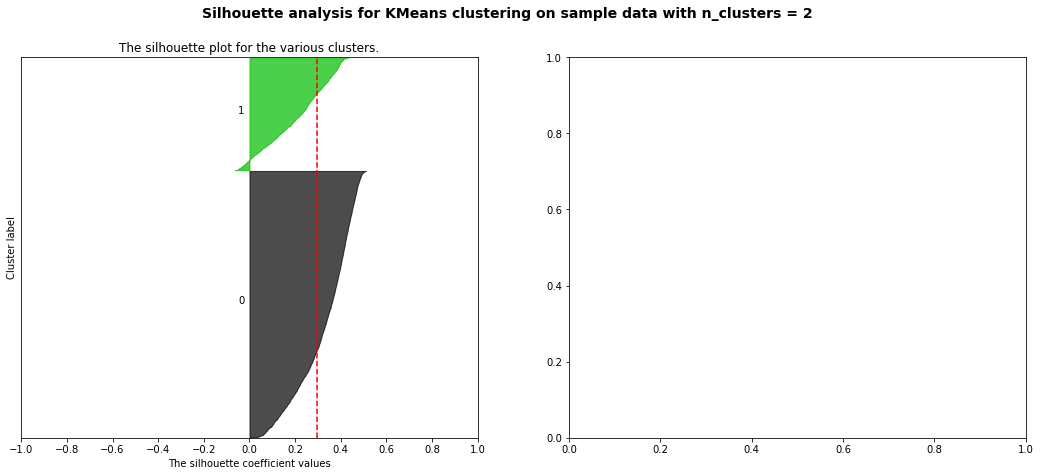

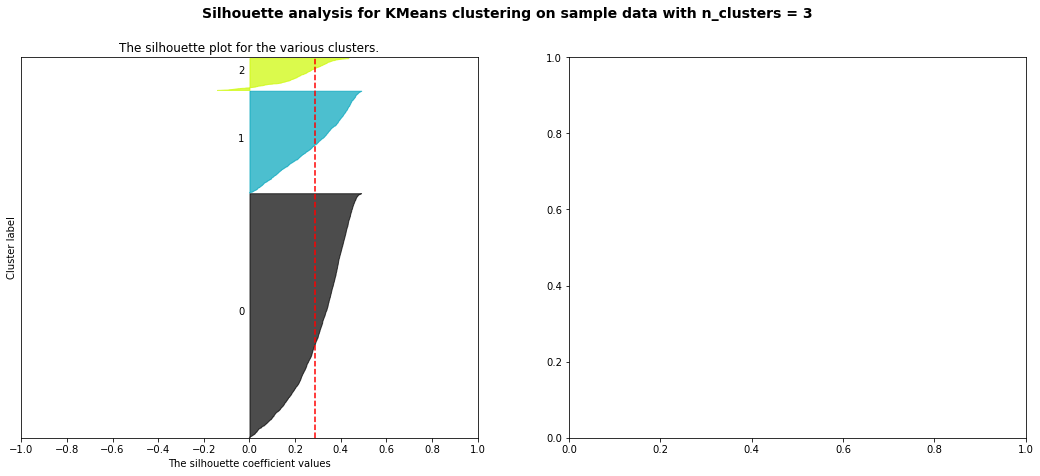

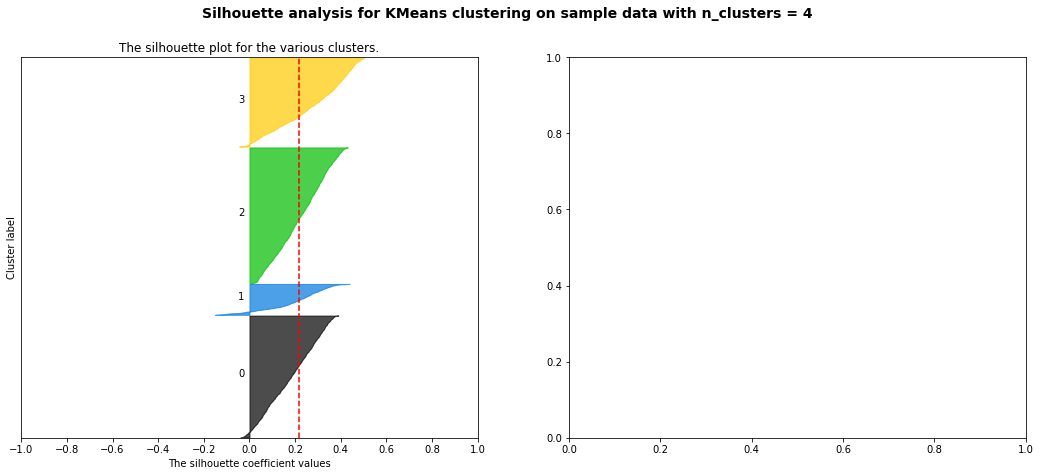

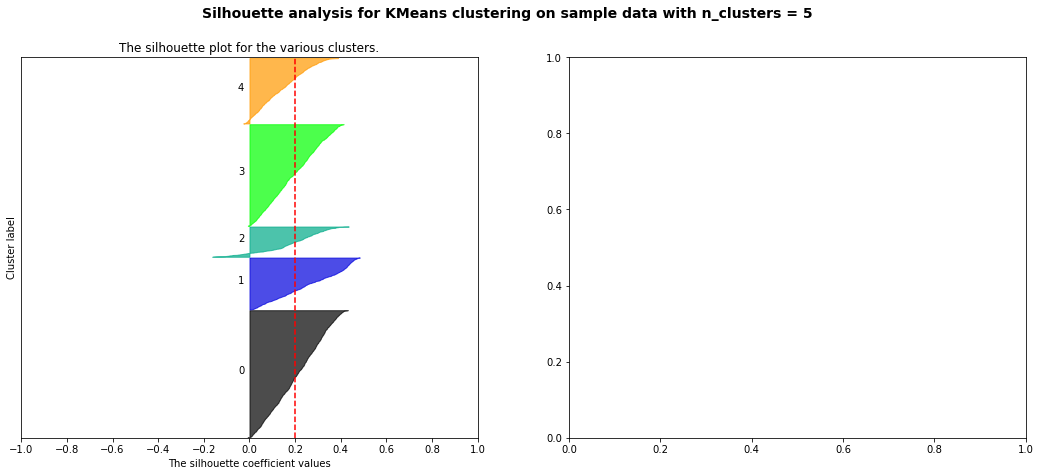

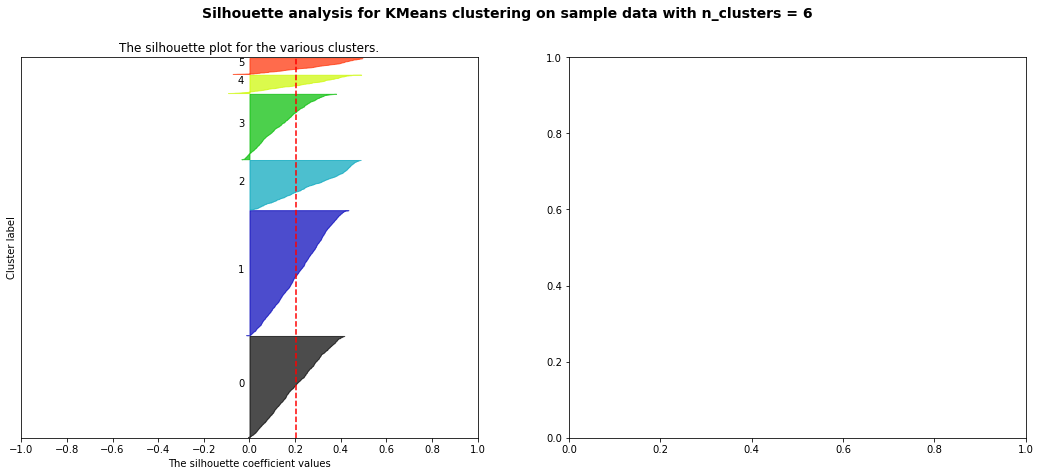

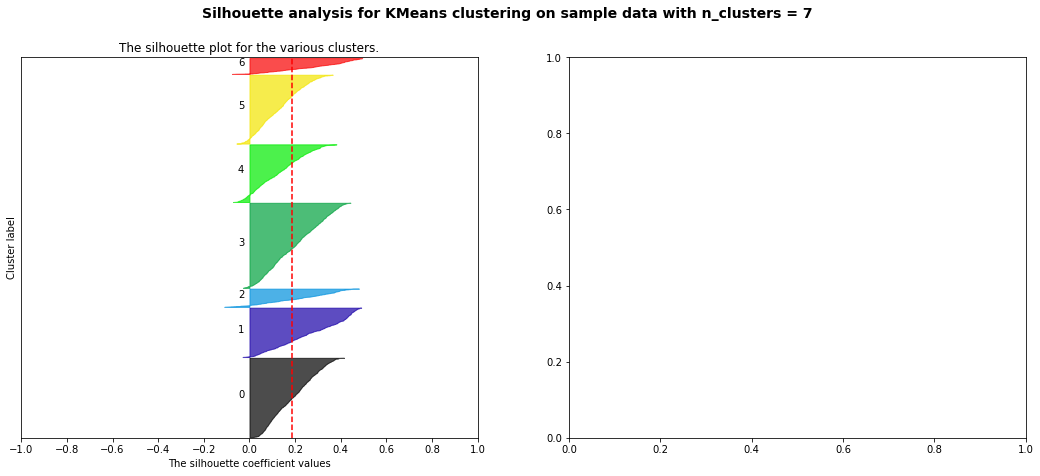

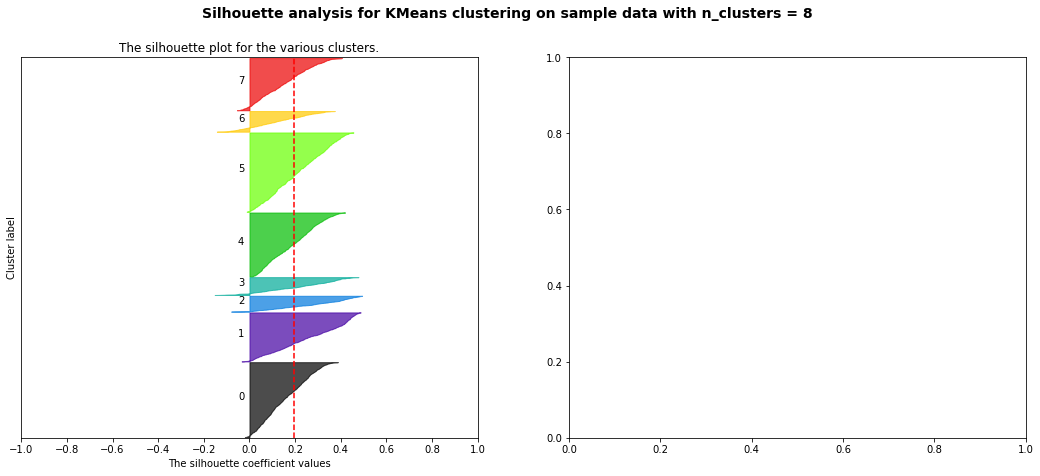

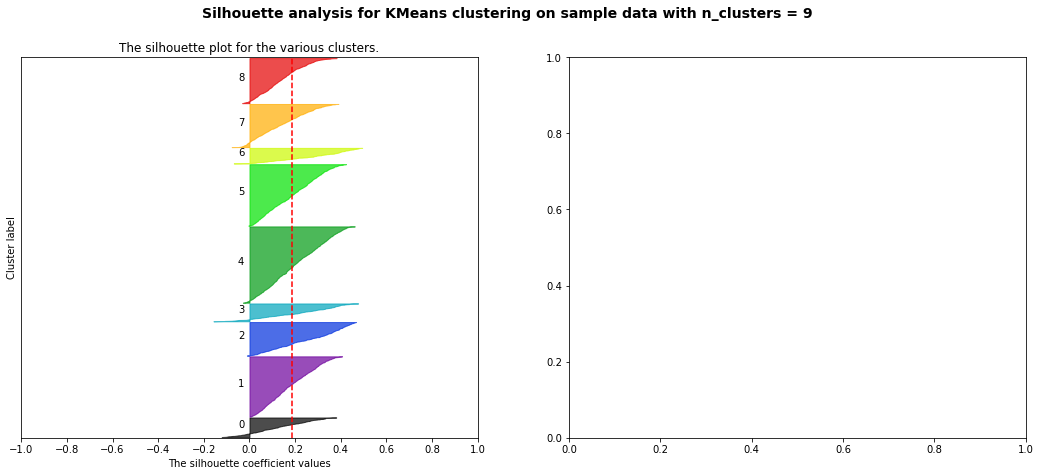

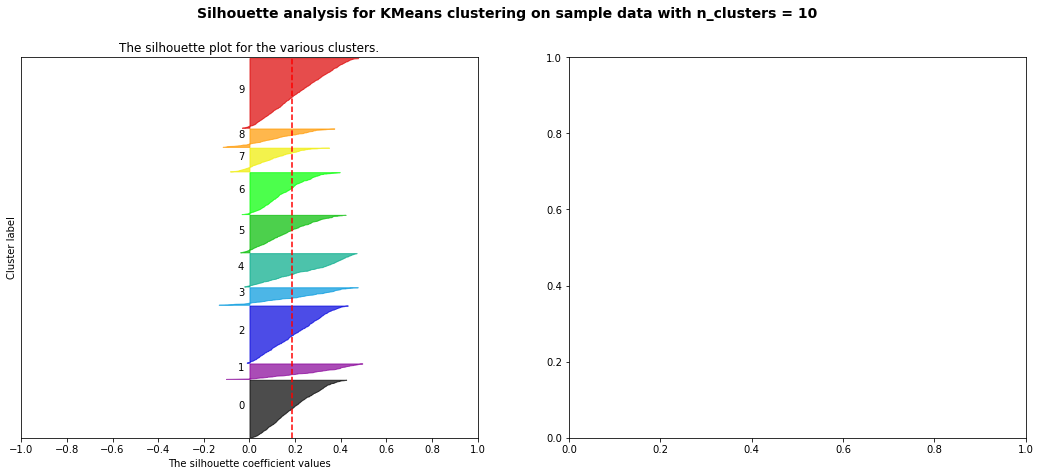

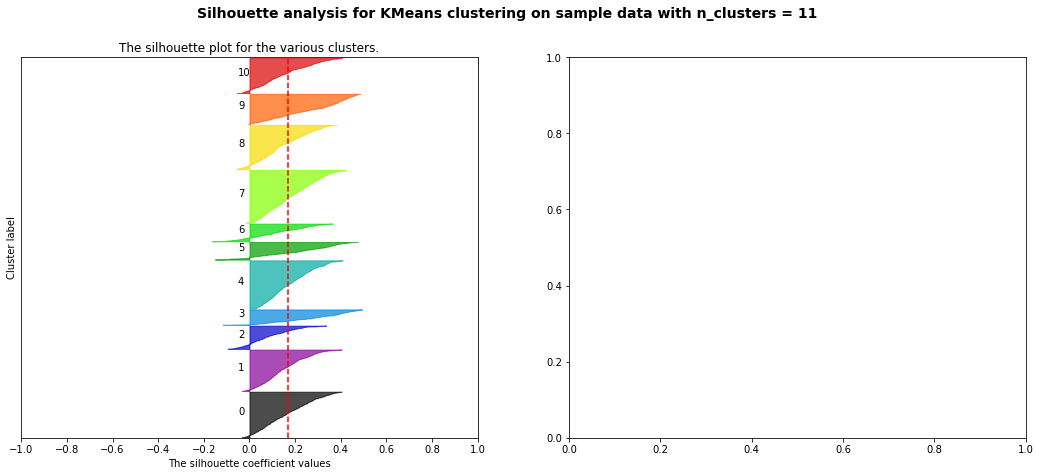

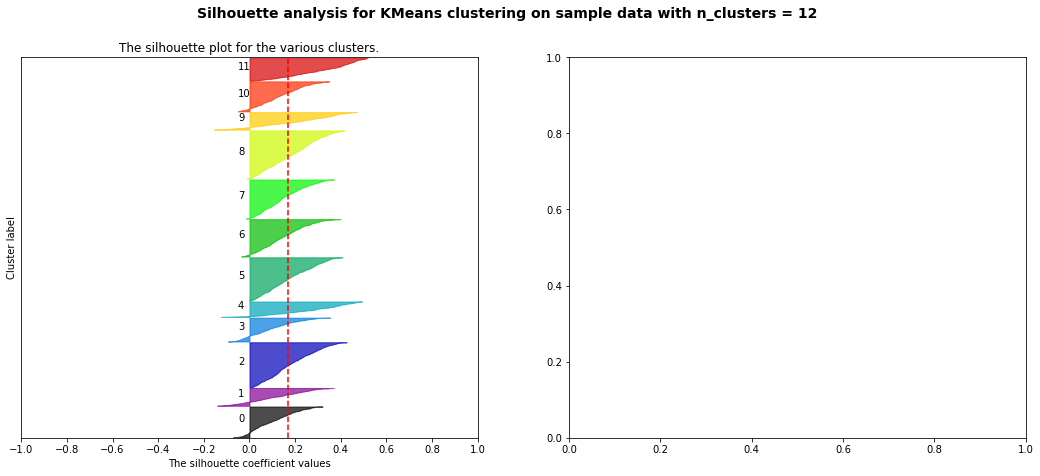

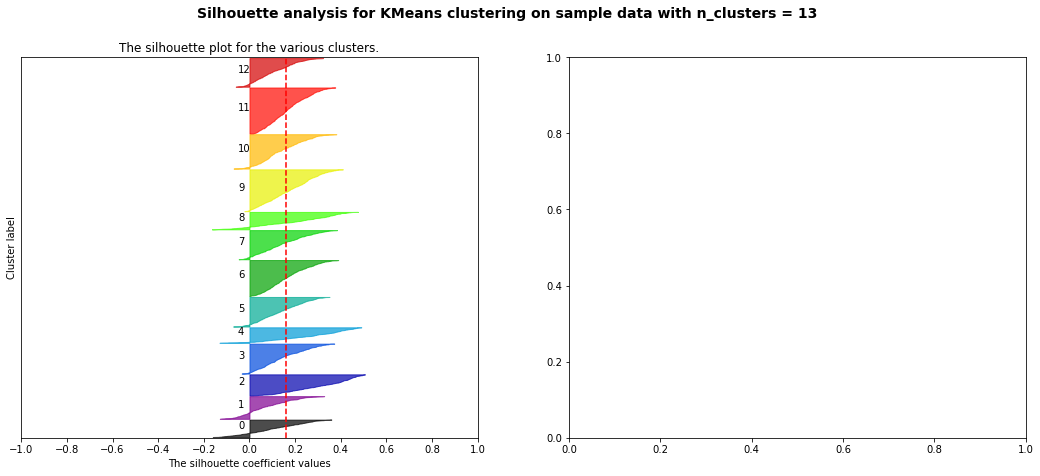

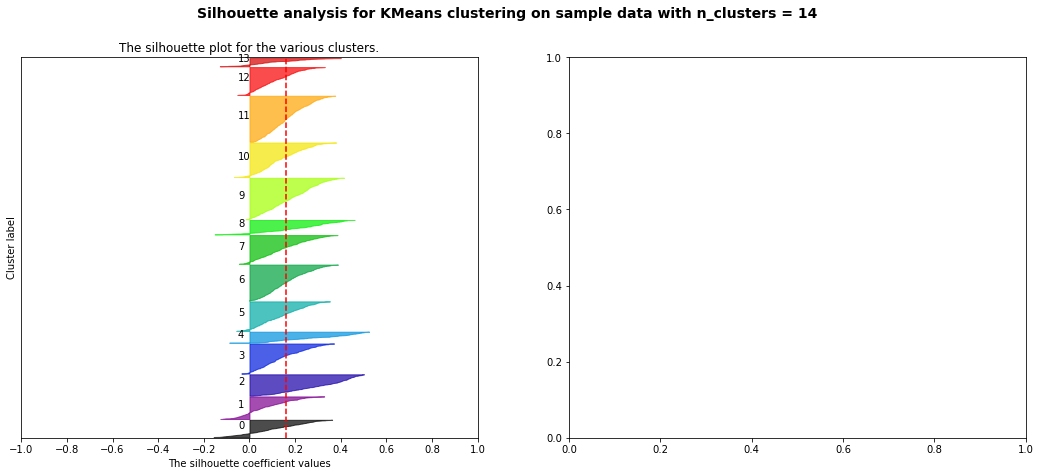

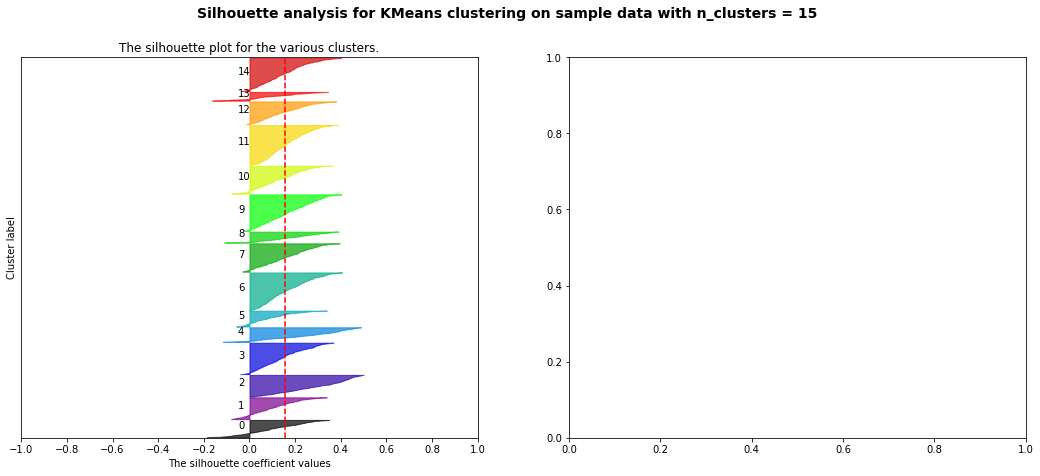

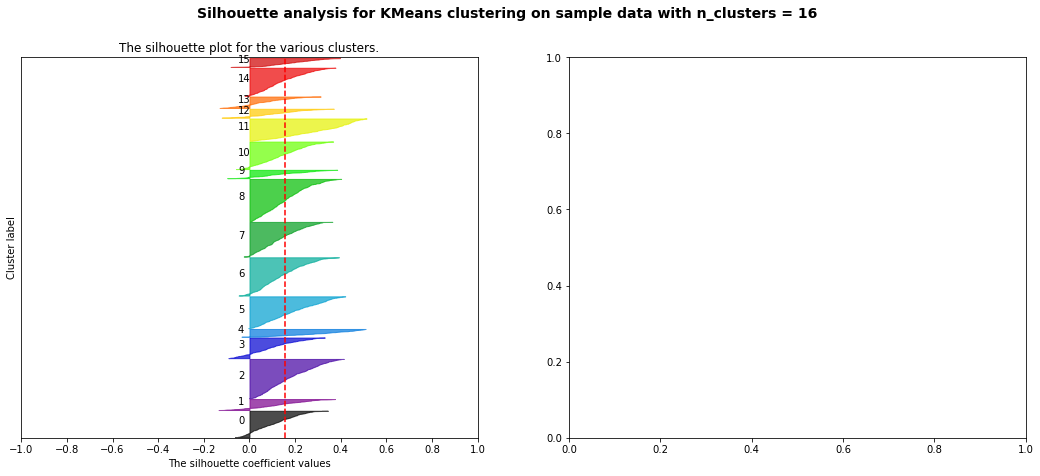

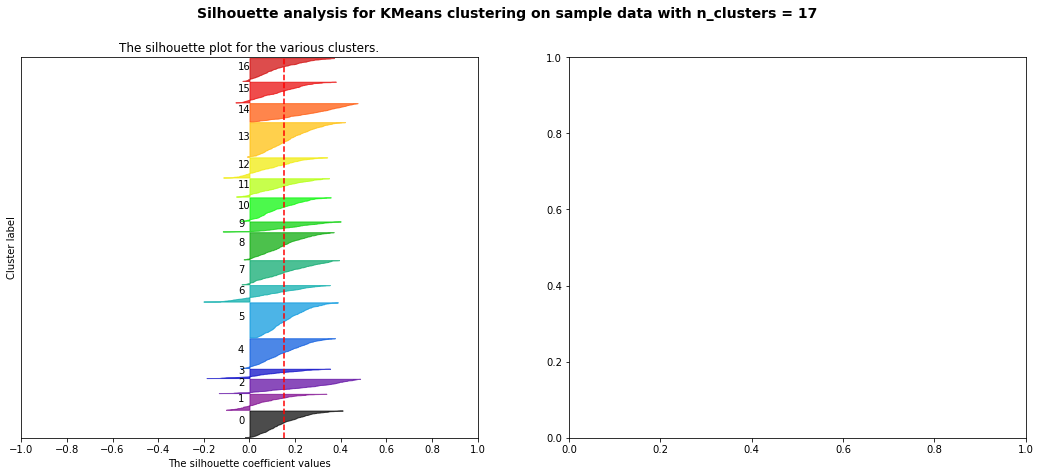

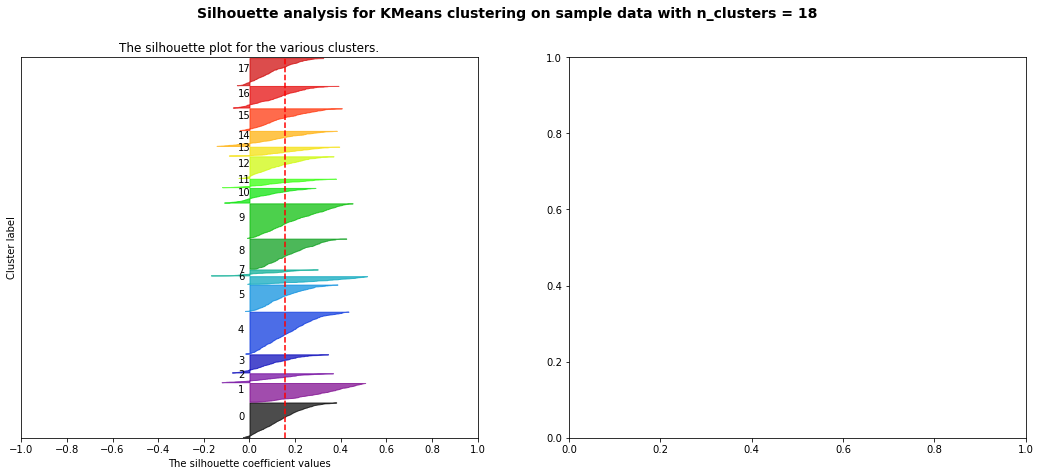

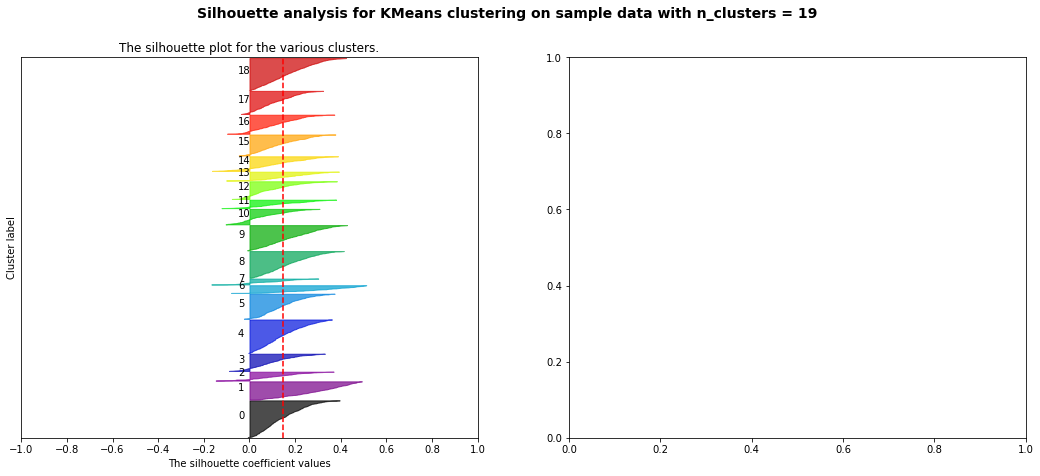

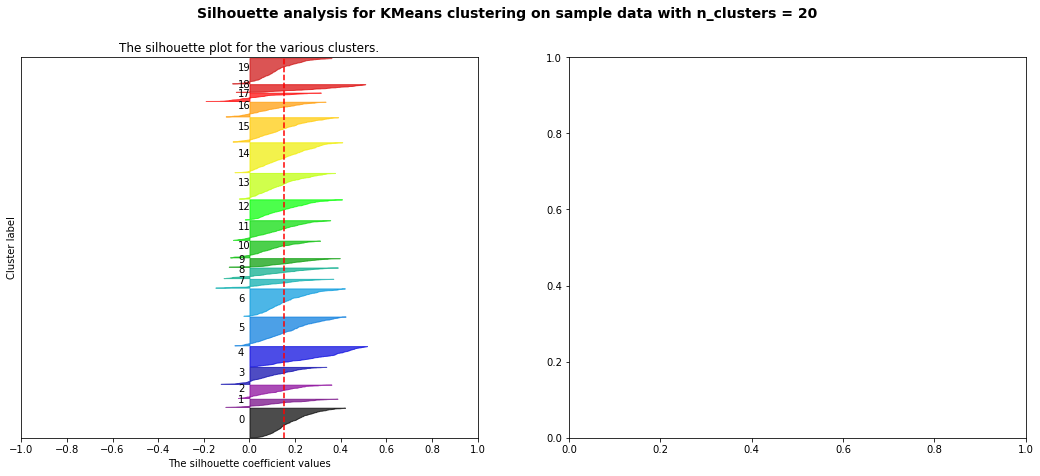

In [17]:
print(__doc__)

# # Generating the sample data from make_blobs
# # This particular setting has one distinct cluster and 3 clusters placed close
# # together.
# X, y = make_blobs(n_samples=500,
#                   n_features=2,
#                   centers=4,
#                   cluster_std=1,
#                   center_box=(-10.0, 10.0),
#                   shuffle=True,
#                   random_state=1)  # For reproducibility

# range_n_clusters = [2, 3, 4, 5, 6]

# TODO: change for more graphs
for n_clusters in range(2,21):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1] TODO
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(data)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(data, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(data, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-1,-0.8,-0.6,-0.4,-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

#     # 2nd Plot showing the actual clusters formed
#     colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
#     ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
#                 c=colors, edgecolor='k')

#     # Labeling the clusters
#     centers = clusterer.cluster_centers_
#     # Draw white circles at cluster centers
#     ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
#                 c="white", alpha=1, s=200, edgecolor='k')

#     for i, c in enumerate(centers):
#         ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
#                     s=50, edgecolor='k')

#     ax2.set_title("The visualization of the clustered data.")
#     ax2.set_xlabel("Feature space for the 1st feature")
#     ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

Source: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

Through some of the clustering scores, it seems clear that the k-means algorithm here is flawed in some way here. One thing that immediately strikes me here is that the variances much different between, as displayed by the previous graphs. Furthermore, we also cannot know that the clusters will have an approximately equal number of datapoints, which might cause the algorithm to select higher. On top of that, I cannot count on the fact that my clusters will not be spherical in nature.


Given all this, I don't think it would be enough to just standardize or scale my data.To quote an
[article](http://varianceexplained.org/r/kmeans-free-lunch/#:~:text=k%2Dmeans%20assume%20the%20variance,then%20k%2Dmeans%20will%20fail.)
by David Robinson, maybe I was trying to fit a square peg in a round hole by using k means for the job! As a result, I looked to other clustering algorithms that migh be of use.

## Data Processing